In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy.special


%matplotlib inline

## Generate Poisson data

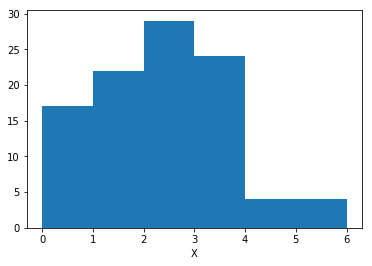

In [2]:
N = 100  # size of toy data
shape = 9. 
scale = .5
true_lam = 2.

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins=6);
plt.xlabel('X');

In [3]:
class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = torch.exp(self.scale_out(act))
        out_scale = torch.exp(self.shape_out(act))
        return (out_shape, out_scale)

In [4]:
# this one is used to approximate the posterior with a mixture of Gaussians 
def gauss_pdf(y, mu, sigma, log=False):
    result = -0.5*torch.log(2*np.pi*sigma**2) - 1/(2*sigma**2) * (y.expand_as(mu) - mu)**2
    if log:
        return result
    else: 
        return torch.exp(result)
    
# magical gammaln fun from pyro 
def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t


def gamma_pdf(x, shape, scale, log=False): 
    alpha = shape
    beta = 1 / scale
    
    ll_1 = -beta * x
    ll_2 = (alpha - 1.0) * torch.log(x)
    ll_3 = alpha * torch.log(beta)
    ll_4 = -log_gamma(alpha)
    result = torch.sum(ll_1 + ll_2 + ll_3 + ll_4, -1)
    if log:
        return result
    else: 
        return torch.exp(result)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

## Use a MDN to learn the mean of the Poisson model
So first we do not do model comparison but just try to learn the mean lambda of the Poisson distribution the observed data comes from. 

To this end we set up a Poisson model with a prior on the mean lambda and then use a MDN to learn the posterior over lambda given the data. 

In [5]:
# we need to define a generative model to generate samples (theta, x)
def generate_dataset(N, m):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(N): 
        # sample from the prior 
        lam = np.random.gamma(shape, scale)

        # generate samples
        x = np.random.poisson(lam=lam, size=m)
        
        # as data we append the summary stats
        X.append(calculate_stats(x).astype(float)) 
        thetas.append([lam])
    
    return X, np.array(thetas)

# calculate summary stats, for poisson this is just x, so for a vector it is sum x
def calculate_stats(x): 
    sx = np.array([np.mean(x)])
    #sx = x
    return sx


In [6]:
model = MDN_phi(ndim_input=1, n_components=1)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))


In [7]:
X, Y = generate_dataset(1000, N)

In [8]:
train(X, Y)

[epoch 0050] loss: 1.6482
[epoch 0100] loss: 1.6985
[epoch 0150] loss: 1.6765
[epoch 0200] loss: 1.6290
[epoch 0250] loss: 1.6472
[epoch 0300] loss: 1.6303
[epoch 0350] loss: 1.6702
[epoch 0400] loss: 1.6644
[epoch 0450] loss: 1.6746
[epoch 0500] loss: 1.6128


In [9]:
# now evaluate the model at the observed data 
stats_o = np.array(calculate_stats(X_o).astype(float)).reshape(1, 1)

X_var = Variable(torch.Tensor(stats_o))

(out_shape, out_scale) = model(X_var)

In [10]:
thetas = np.linspace(0, 10, 100)

# make sure all variabel have dimensions (N, 1)
out_shapes = Variable(torch.Tensor(out_shape.data * torch.ones(thetas.size))).view(N, 1)
out_scales = Variable(torch.Tensor(out_scale.data * torch.ones(thetas.size))).view(N, 1)

post = gamma_pdf(Variable(torch.Tensor(thetas.reshape(N, 1))), out_shapes, out_scales, log=False).data.numpy()

prior = gamma.pdf(x=thetas, a=shape, loc=0, scale=scale)

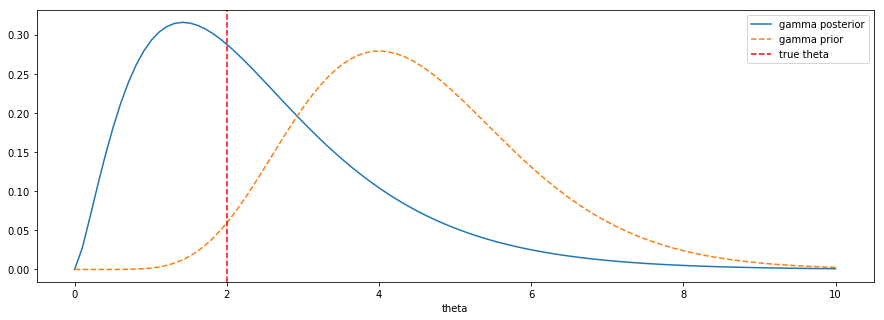

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post, label='gamma posterior')
plt.plot(thetas, prior, '--', label='gamma prior')
plt.axvline(x=true_lam, label='true theta', linestyle='--', color='r')
plt.xlabel('theta')
plt.legend();